In [3]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle
import yaml
from pathlib import Path

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import data_loader
import plotter
import plot_utils
import utils
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-08-02 07:27:50.464690: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-02 07:27:50.560631: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-02 07:27:50.560670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-02 07:27:50.573069: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-02 07:27:50.601964: I tensorflow/core/platform/cpu_feature_guar

In [4]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [3]:
box_size = 1000.0  
n_grid = 128
n_grid_orig = 512
#tag_params = '_p5_n10000'
tag_params = '_quijote_p0_n1000'
idx_LH = 0
#subdir_prefix = 'LH'
subdir_prefix = 'mock'


# change this directory path as needed
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_params}'
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
#fn_fields_zspace = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_zspace_deconvolved_{idx_LH}.npy'

bias_terms_eul = np.load(fn_fields)
#bias_terms_eul_zspace = np.load(fn_fields_zspace)
print(bias_terms_eul.shape)

(5, 128, 128, 128)


In [4]:
params_df, param_dict_fixed = data_loader.load_cosmo_params(tag_params)
cosmo = utils.get_cosmo(param_dict_fixed)

In [5]:
# Choose a bias vector (order: b1, b2, bs2, bl)
bias_vector = [1.0, 0.0, 0.0, 0.0]  # example: pure linear bias

# Get the tracer field (normalized)
tracer_field = utils.get_tracer_field(bias_terms_eul, bias_vector, n_grid_norm=n_grid_orig)
print(tracer_field.std())

1.8390275629823127e-06


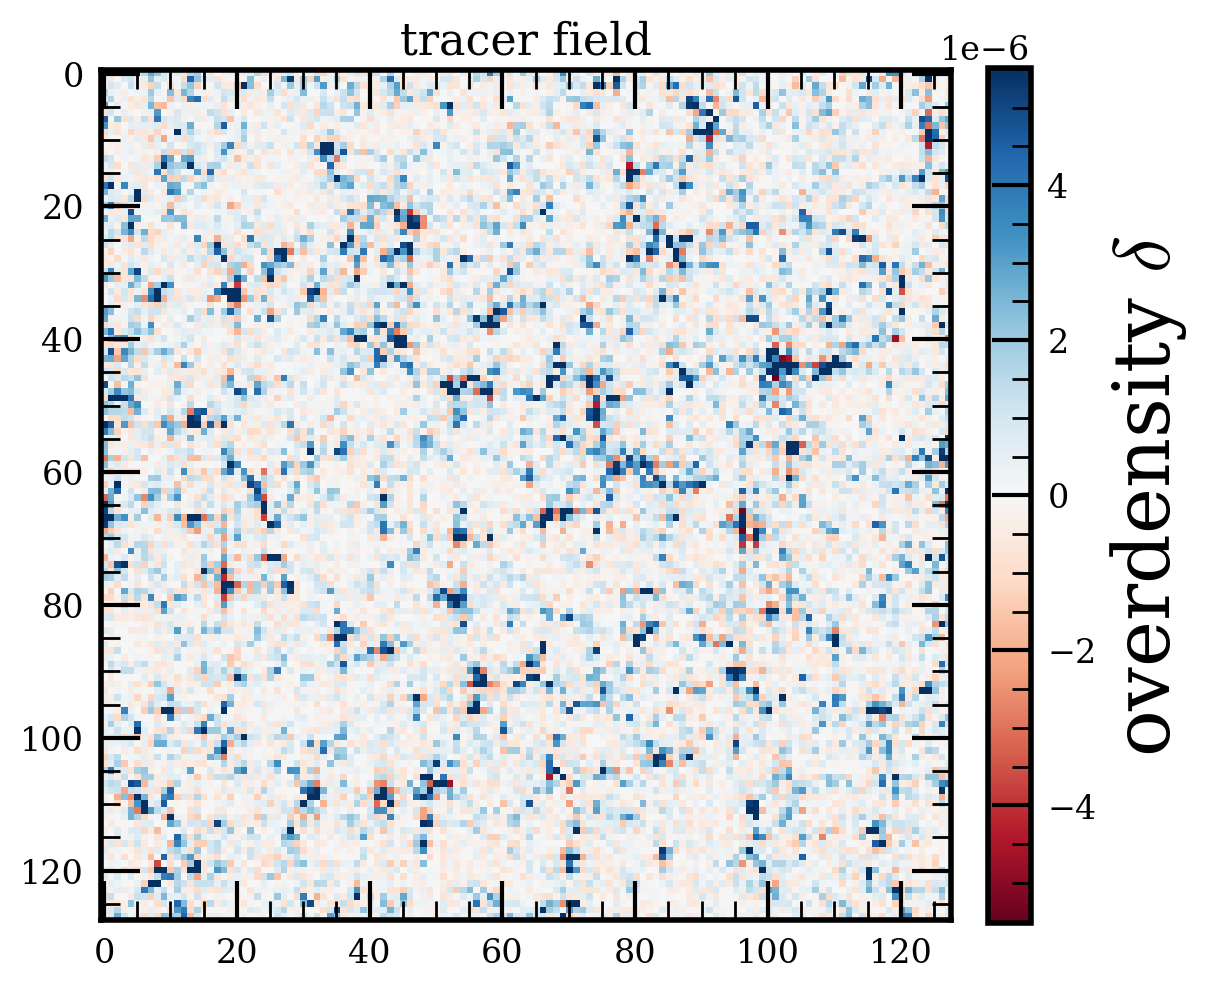

In [6]:
plotter.plot_overdensity_field(tracer_field, title='tracer field')

In [7]:
nbar = 2.2e-4
rng = np.random.default_rng(seed=42)  # or np.random.default_rng() for random seed
noise_field = rng.normal(0, 1, bias_terms_eul[0].shape)
noise_field_ndens = np.sqrt(nbar) * noise_field
print(noise_field_ndens.std())

0.01483027947334672


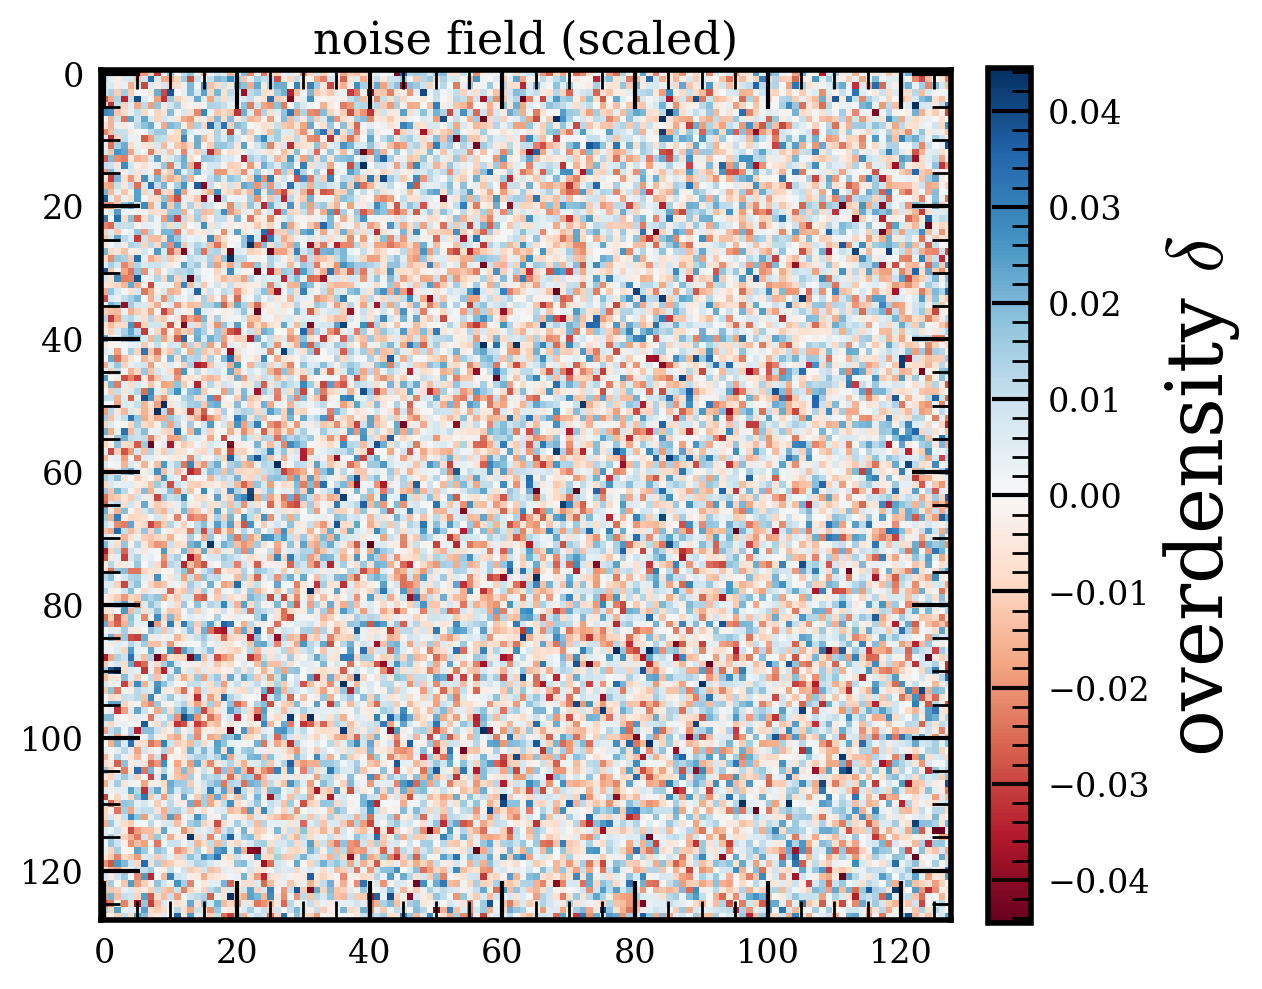

In [8]:
plotter.plot_overdensity_field(noise_field_ndens, title='noise field (scaled)')

In [9]:
cell_size = box_size / n_grid  # Mpc/h per cell
cell_volume = cell_size**3

rms_cell = 1 / np.sqrt(nbar * cell_volume)
print(cell_volume, rms_cell)
noise_field_cell = rms_cell * rng.standard_normal(tracer_field.shape)
noise_field_cell = noise_field_cell/n_grid**3
print(noise_field_cell.std())
# You can still compute power spectra from this

476.837158203125 3.0874761684762992
1.4718064990517275e-06


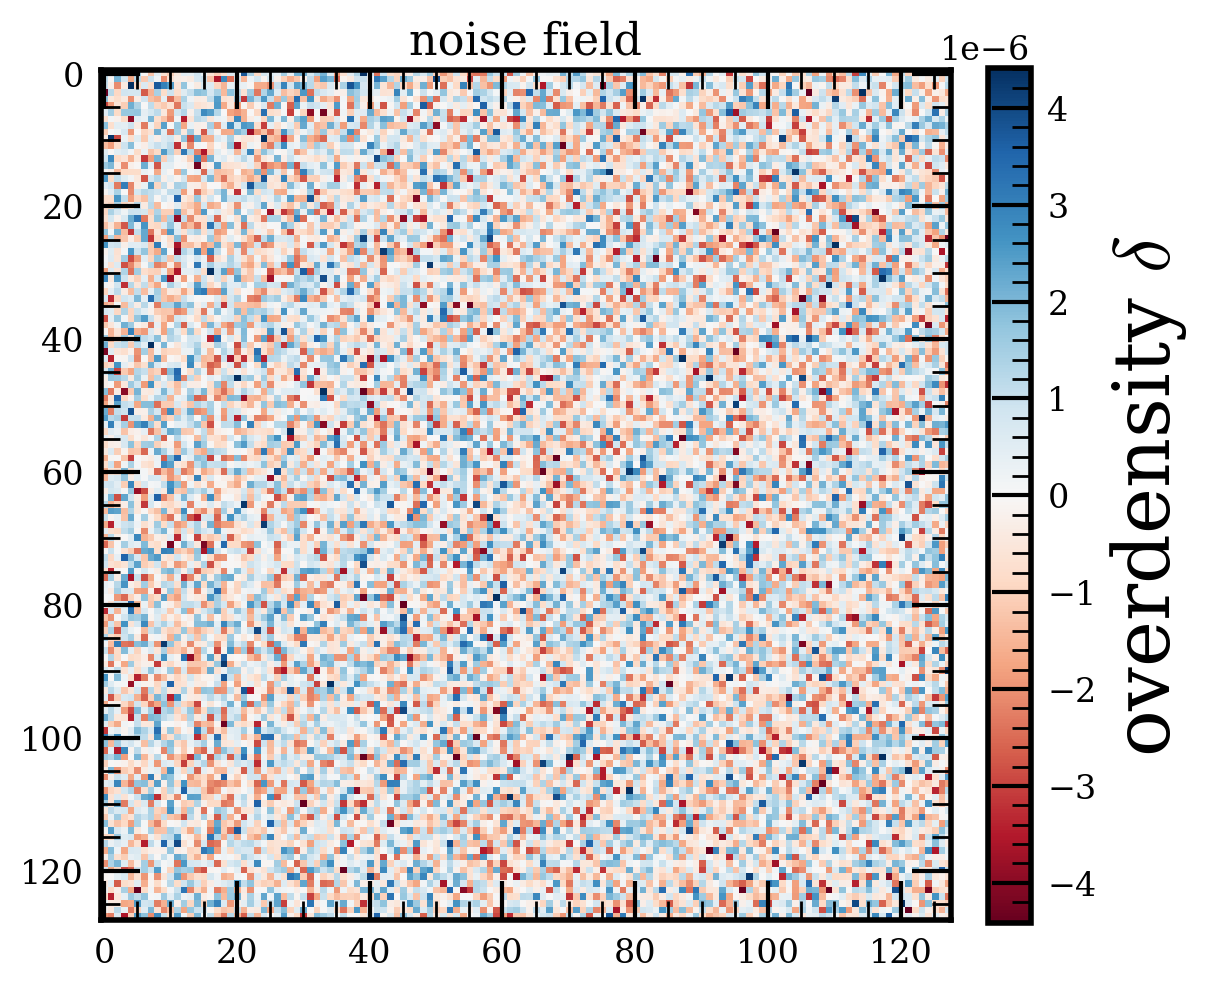

In [10]:
plotter.plot_overdensity_field(noise_field_cell, title='noise field')

In [11]:
A_noise = 1.0  
tracer_noise_field = tracer_field + A_noise * noise_field_cell
print(tracer_noise_field.std())

2.3570855125612913e-06


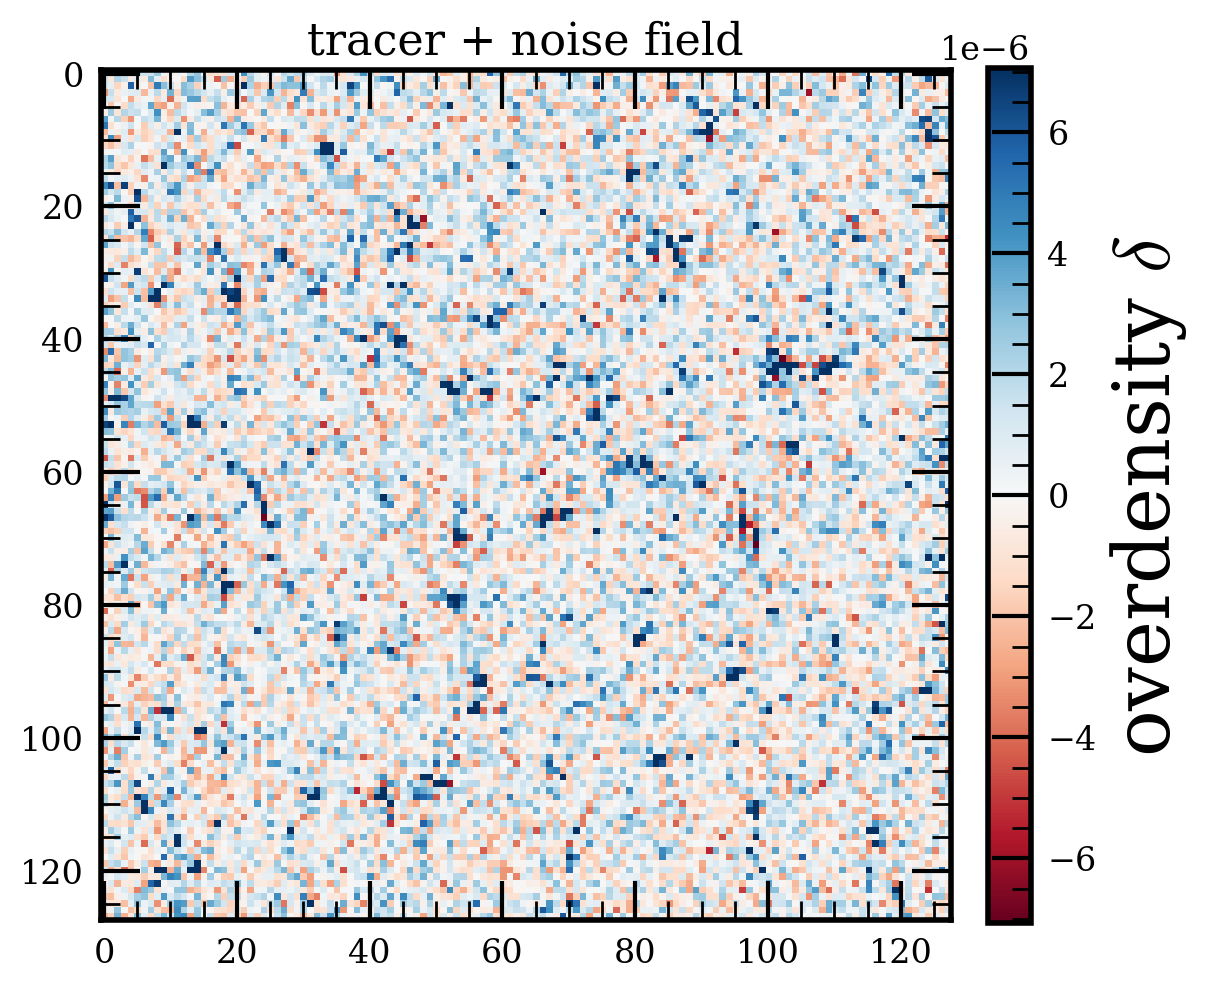

In [12]:
plotter.plot_overdensity_field(tracer_noise_field, title='tracer + noise field')

In [16]:
import compute_biased_pks_fields

pk_noise = compute_biased_pks_fields.compute_pk(
    noise_field_cell, cosmo, box_size, n_threads=4
)

# Compute pk of tracer field
pk_tracer = compute_biased_pks_fields.compute_pk(
    tracer_field, cosmo, box_size, n_threads=4
)

# Compute pk of sum (tracer + A_noise * noise)
pk_sum = compute_biased_pks_fields.compute_pk(
    tracer_noise_field, cosmo, box_size, n_threads=4
)

Computing pk, using n_grid =  128


2025-06-09 19:05:18,361 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-06-09 19:05:18,412 bacco.statistics :  ...done in 0.0511 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00289738 (grid1) 0.00289738 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.003738 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.032244 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000188 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-06-09 19:05:18,413 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-06-09 19:05:18,460 bacco.statistics :  ...done in 0.0474 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.003727 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.031513 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000189 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-06-09 19:05:18,461 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-06-09 19:05:18,509 bacco.statistics :  ...done in 0.0484 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.0029 (grid1) 1.0029 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.003720 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.032811 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000190 secs
bacco.power : Deallocating arrays


In [17]:
1/nbar

4545.454545454545

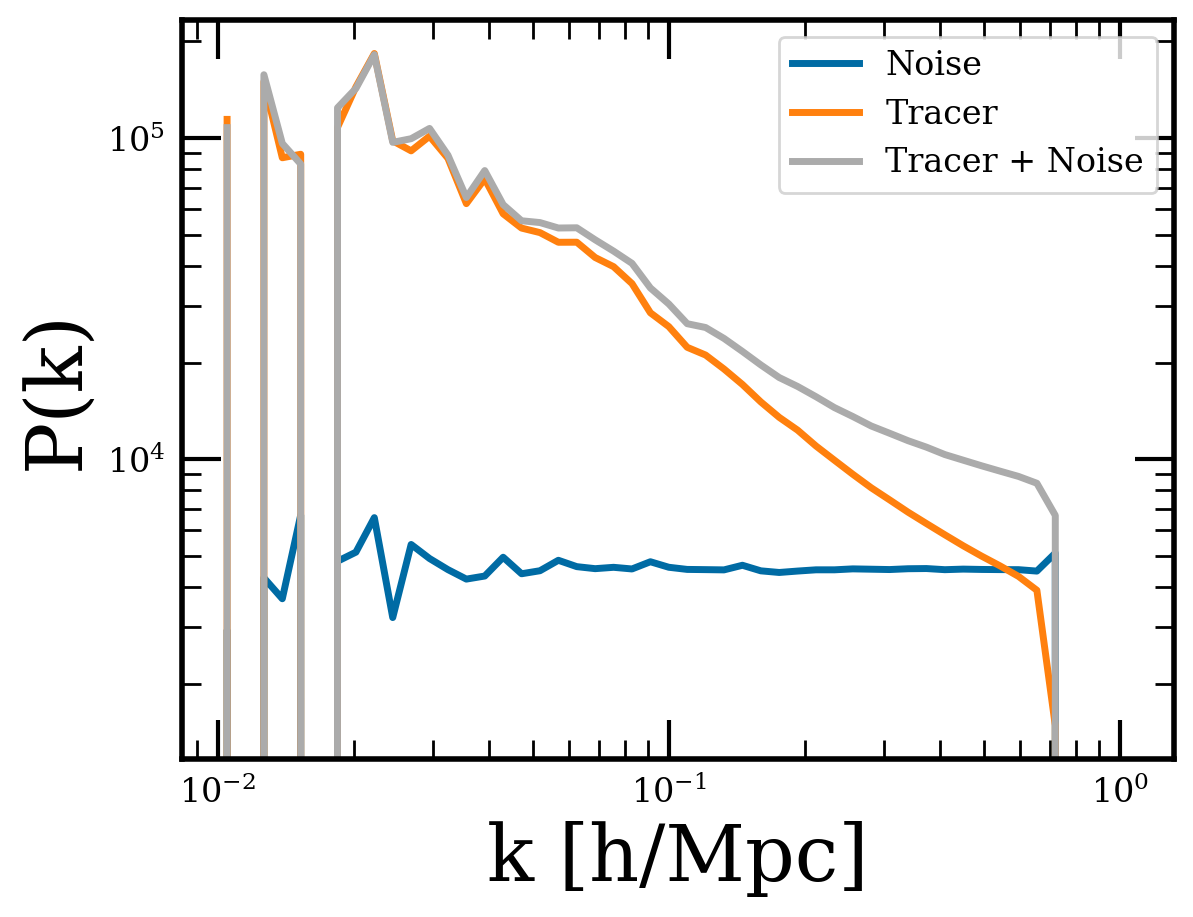

In [18]:
# pk_noise, pk_tracer, pk_sum are dicts with keys like 'k' and 'pk'
plt.figure()
plt.loglog(pk_noise['k'], pk_noise['pk'], label='Noise')
#plt.loglog(pk_noise_norm['k'], pk_noise_norm['pk'], label='Noise')
plt.loglog(pk_tracer['k'], pk_tracer['pk'], label='Tracer')
plt.loglog(pk_sum['k'], pk_sum['pk'], label='Tracer + Noise')
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k)')
plt.legend(fontsize=12)
plt.show()

## Load in saved noise fields

In [4]:
n_mocks = 1000
tag_params = f'_quijote_p0_n{n_mocks}'
tag_biasparams = '_b1000_p0_n1' # for pnn, don't need biasparams
#tag_biasparams = None # for pnn, don't need biasparams
tag_noise = '_noise_quijote_p0_n1000'
tag_Anoise = '_An1_p0_n1'

idx_mock, idx_bias, idx_noise = 0, 0, 0
statistic = 'pk'

In [5]:
tag_mocks = tag_params + tag_biasparams
dir_statistics = f'/scratch/kstoreyf/muchisimocks/data/{statistic}s_mlib/{statistic}s{tag_mocks}'
fn_statistic = f'{dir_statistics}/{statistic}_{idx_mock}.npy'

tag_mocks = tag_params + tag_biasparams + tag_noise + tag_Anoise
dir_statistics = f'/scratch/kstoreyf/muchisimocks/data/{statistic}s_mlib/{statistic}s{tag_mocks}'
fn_statistic_noisy = f'{dir_statistics}/{statistic}_{idx_mock}_n{idx_noise}.npy'

tag_mocks = tag_noise
dir_statistics = f'/scratch/kstoreyf/muchisimocks/data/{statistic}s_mlib/{statistic}s{tag_mocks}'
fn_statistic_noise = f'{dir_statistics}/{statistic}_n{idx_noise}.npy'

pk = np.load(fn_statistic, allow_pickle=True).item()
pk_noise = np.load(fn_statistic_noise, allow_pickle=True).item()
pk_noisy = np.load(fn_statistic_noisy, allow_pickle=True).item()

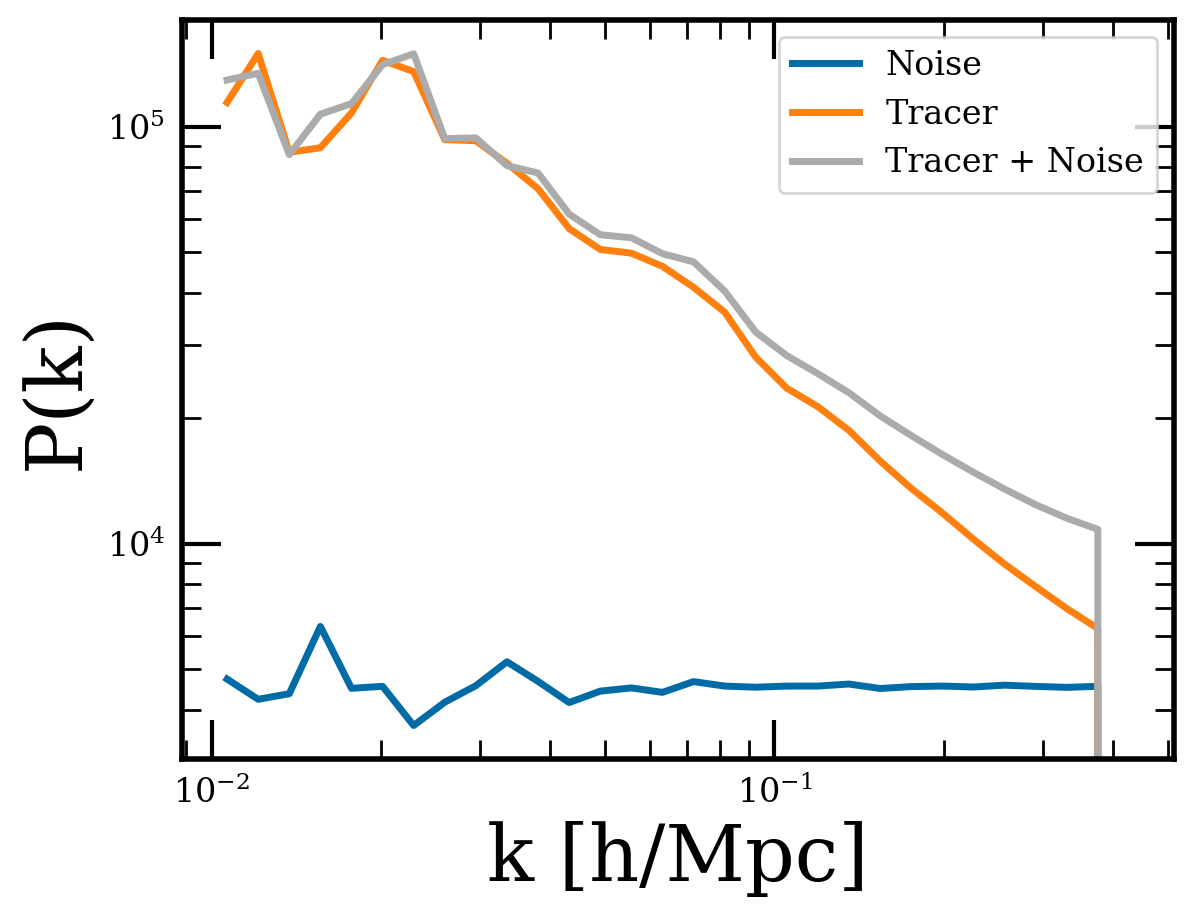

In [6]:
# pk_noise, pk_tracer, pk_sum are dicts with keys like 'k' and 'pk'
plt.figure()
plt.loglog(pk_noise['k'], pk_noise['pk'], label='Noise')
plt.loglog(pk['k'], pk['pk'], label='Tracer')
plt.loglog(pk_noisy['k'], pk_noisy['pk'], label='Tracer + Noise')
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k)')
plt.legend(fontsize=12)
plt.show()

## Try recovery test on cosmic variance set with noise; training set without noise

In [5]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
#tag_biasparams = '_biaszen_p4_n10000'
tag_biasparams = '_biaszen_p4_n200000'
n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}_ntrain{n_train}' for tag_stats in tag_stats_arr
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [6]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary = [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]

In [7]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_datagen_test_fixed = ''
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary)
print(theta_test_fixed.shape)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
extents = {**dict_bounds_cosmo, **dict_bounds_bias}
print(theta_test_fixed)
print(param_names_vary)
idx_obs = 0
title = 'recovery test: mean of 1000 fixed cosmo mocks'
tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + tag_datagen_test_fixed + '_mean' for tag_stats in tag_stats_arr]

(9,)
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.    ]
['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']


In [8]:
# load fixed-cosmo test set WITH NOISE
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_test_fixed = '_noise_quijote_p0_n1000'
tag_Anoise_test_fixed = '_An1_p0_n1'
tag_datagen_test_fixed = ''
# this should be the same as above bc in this case tag_Anoise is just one value (fixed), but here for posterity
# ah we can only recover thetas that we've trained on, so in this case we wouldnt want Anoise anyway
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                    #tag_Anoise_test=tag_Anoise_test_fixed,
                                    cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary)
print(theta_test_fixed.shape)

# get bounds (training set)
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
extents = {**dict_bounds_cosmo, **dict_bounds_bias}
print(theta_test_fixed)
print(param_names_vary)
idx_obs = 0
title = 'recovery test: mean of 1000 fixed cosmo mocks'
# TODO figure out if the noise tags are ok as empty strings if not given, or need Nones
tag_paramsall_test_fixed = tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_test_fixed + tag_Anoise_test_fixed
tags_test_noisy = ['_'+data_mode + tag_stats + tag_paramsall_test_fixed + tag_datagen_test_fixed + '_mean' for tag_stats in tag_stats_arr]

(9,)
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.    ]
['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']


fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_quijote_p0_n1000_An1_p0_n1_mean_pred.npy


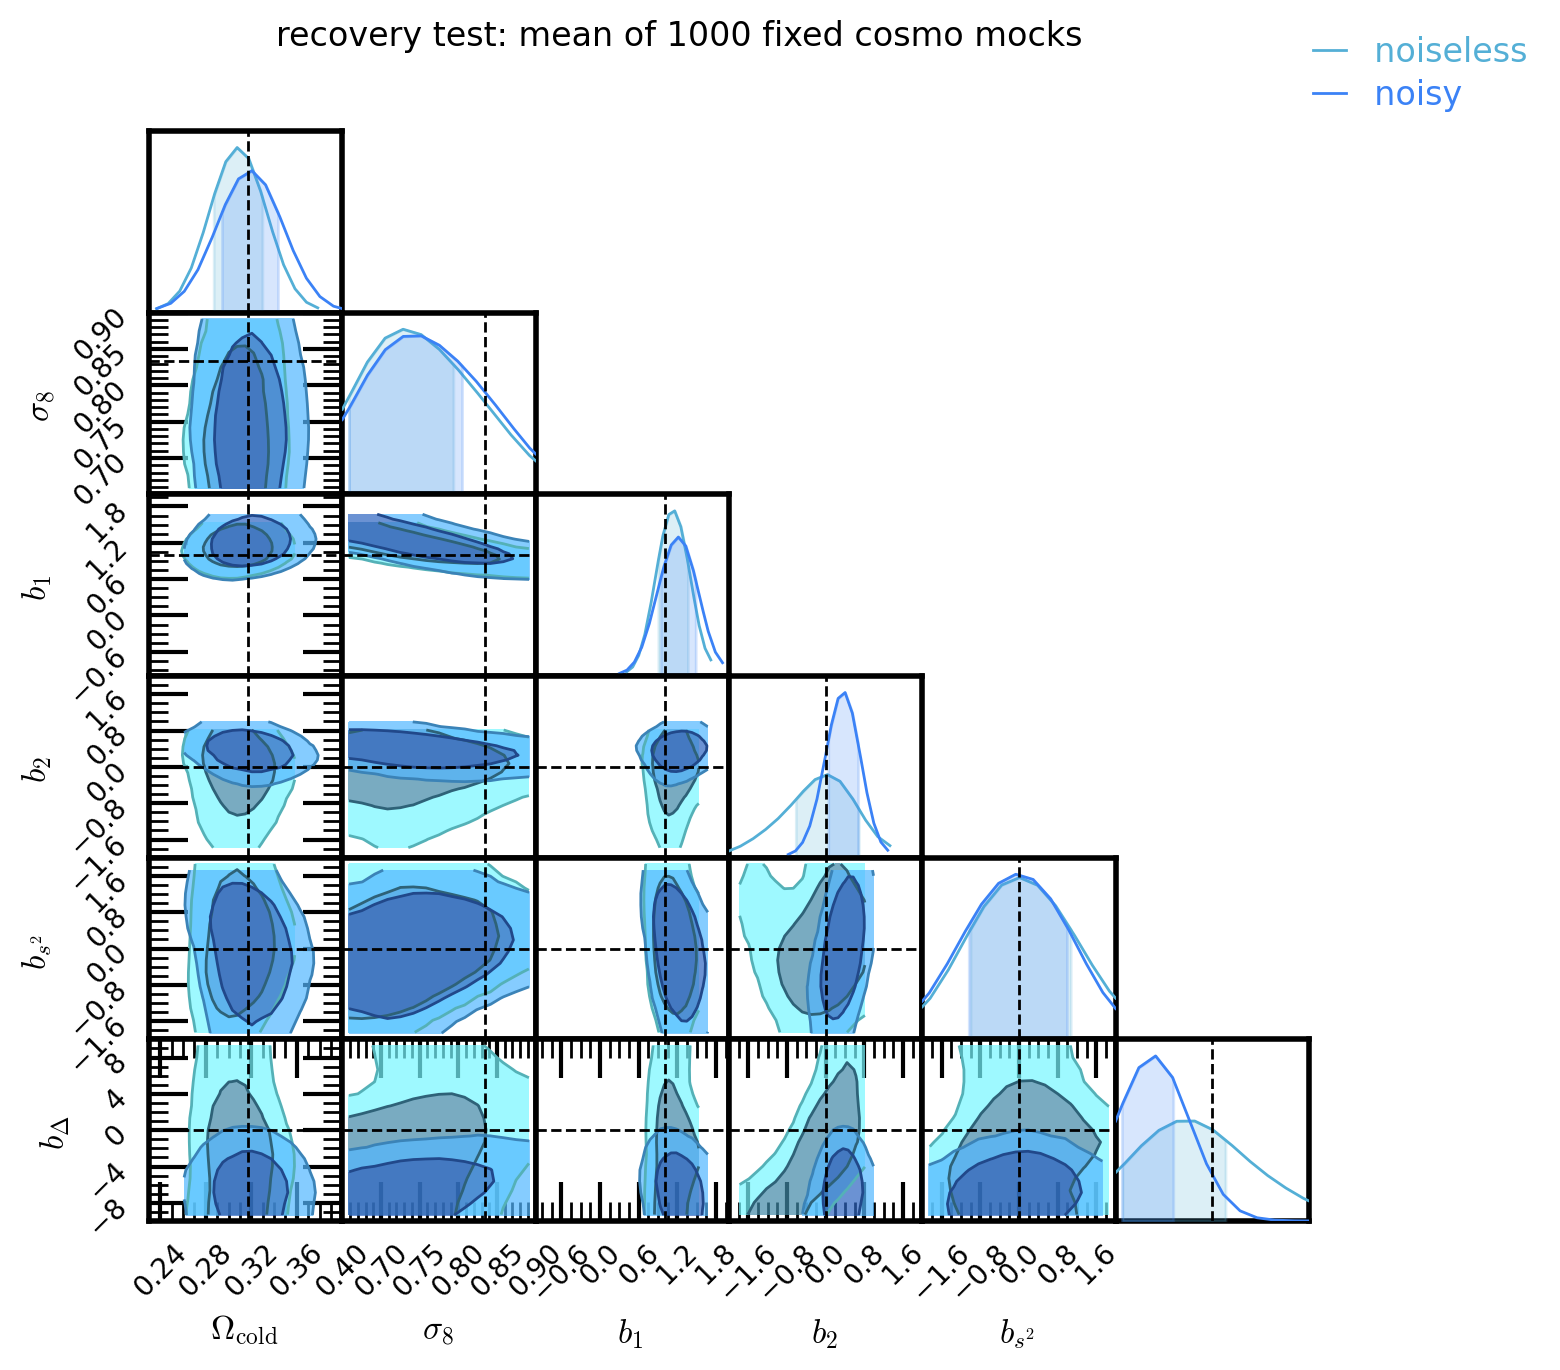

In [9]:
#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
theta_test_fixed_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

tags_test_show = [tags_test[0], tags_test_noisy[0]]
inf_methods_show = [inf_methods[0]]*len(tags_test_show)
tags_inf_show = [tags_inf[0]]*len(tags_test_show)
colors = [color_pk, 'blue']
labels = ['noiseless', 'noisy']

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_fixed_show, 
                        inf_methods_show, tags_inf_show, tags_test=tags_test_show,
                        colors=colors, labels=labels,
                        title=title, extents=extents)